# Non-stationary SGS with adaptive partitioning

Often you may encounter an environment where the spatial statistics are not uniform throughout a region. This is known as non-stationarity. For example, topography can be rough in some places but smooth in others. Here, we demonstrate how to implement SGS with multiple variograms assigned to different regions. We use GStatSim's **adaptive_partioning** function to recursively quarter cells in the study region until the the number of samples contained within a cell is below the **max_points** or the size of the cell would be below the **min_length** if we partion it an additional time.

In [1]:
import numpy as np
from numpy.random import default_rng
import random
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LightSource
from matplotlib import ticker
from sklearn.preprocessing import QuantileTransformer 
import skgstat as skg
from skgstat import models
import gstatsim as gs

## Load and plot data

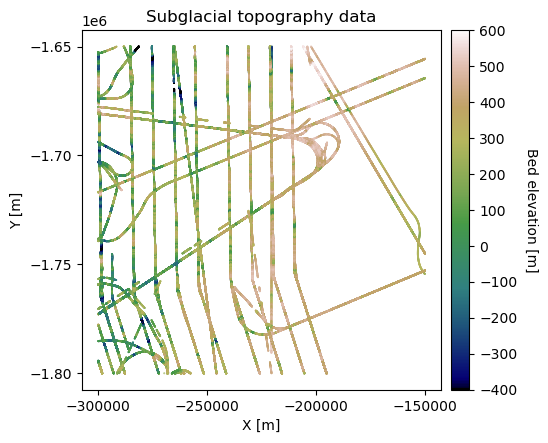

In [2]:
df_bed = pd.read_csv('data/greenland_test_data.csv')

# remove erroneously high values due to bad bed picks
df_bed = df_bed[df_bed["Bed"] <= 700]  

# plot data
fig = plt.figure(figsize = (5,5))
ax = plt.gca()
im = ax.scatter(df_bed['X'], df_bed['Y'], c=df_bed['Bed'], vmin=-400, vmax=600, 
                     marker='.', s=0.5, cmap='gist_earth')
plt.title('Subglacial topography data')
plt.xlabel('X [m]'); plt.ylabel('Y [m]')
plt.locator_params(nbins=5)
plt.axis('scaled')

# make colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(-400, 600, 11), cax=cax)
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=15)
plt.show()

## Grid and transform data

In [3]:
# grid data to 100 m resolution and remove coordinates with NaNs
res = 1000
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(df_bed, 'X', 'Y', 'Bed', res)
df_grid = df_grid[df_grid["Z"].isnull() == False]
df_grid = df_grid.rename(columns = {"Z": "Bed"})

# normal score transformation
data = df_grid['Bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal").fit(data)
df_grid['Nbed'] = nst_trans.transform(data) 

## Group data into different clusters using adaptive partioning

We will break the data into different groups so that each group can be assigned a different variogram. There are many ways the data could be divided. Here we will use the **adaptive_partinioning** function included in GStat-Sim which recursively partitions the data into cells until each contains no more than **max_points** number of samples and is not smaller than **min_length**. This in effect is a partioning based on data density.

Some parameters need to be initialized and passed into the function since it is recursive. The function then updates these parameters when it makes the subsequent calls. Explanation of the parameters is as follows:
* df_bed - pd.DataFrame of data including columns X, Y, and K the cluster id
* xmin, xmax, ymin, ymax - geometric constraints of the current cell being partioned
* i - a counting index to keep track of all the function calls
* max_points - The maximum number of data points in each cell
* min_length - The minimum side length of a cell
* max_iter - optional maximum iterations if potential for runaway recursion

In [4]:
# max_points is the most important parameter
max_points = 800
min_length = 25000
max_iter = None

# initialze parms for full dataset
xmin = df_grid.X.min(); xmax = df_grid.X.max()
ymin = df_grid.Y.min(); ymax = df_grid.Y.max()

i = 0

# initialize cluster column with NaNs to have zero-indexed
df_grid['K'] = np.full(df_grid.shape[0], np.nan)

# begin adaptive partioning
df_grid, i = gs.adaptive_partitioning(df_grid, xmin, xmax, ymin, ymax, i, max_points, min_length, max_iter)

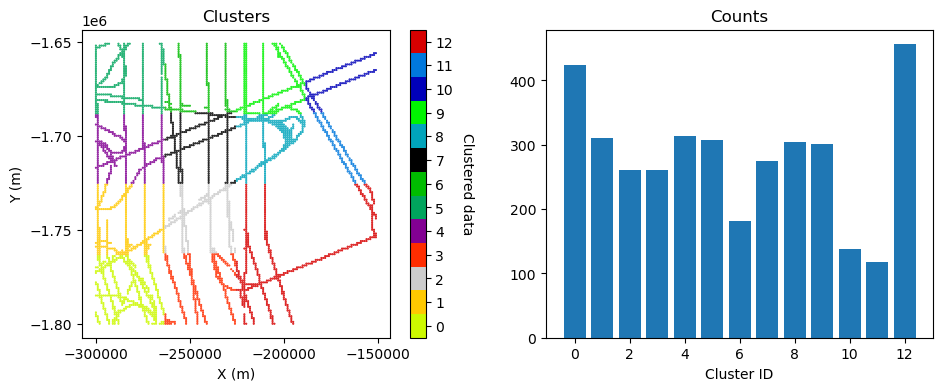

In [5]:
clusters, counts = np.unique(df_grid.K, return_counts=True)
n_clusters = len(clusters)

# randomize colormap
rng = default_rng()
vals = np.linspace(0, 1.0, n_clusters)
rng.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.nipy_spectral(vals))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4))

ax1.locator_params(nbins=5)

im = ax1.scatter(df_grid['X'], df_grid['Y'], c=df_grid['K'], cmap=cmap, marker=".", s=1)
im.set_clim(-0.5, max(clusters)+0.5)
ax1.set_title('Clusters')
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
cbar = plt.colorbar(im, orientation="vertical", ax=ax1)
cbar.set_ticks(np.linspace(0, max(clusters), n_clusters))
cbar.set_ticklabels(range(n_clusters))
cbar.set_label('Clustered data', rotation=270, labelpad=15)
ax1.axis('scaled')

ax2.bar(clusters, counts)
ax2.set_xlabel('Cluster ID')
ax2.set_title('Counts')
plt.show()

## Define variogram parameters for each cluster

Next we need to compute and model the variogram for the subset of data within each cluster.

In [6]:
# experimental variogram parameters
maxlag = 30_000
n_lags = 70

variograms = []

for k in clusters:
    tmp = df_grid[df_grid.K == k]
    coords = tmp[['X', 'Y']].values
    values = tmp['Nbed']
    variograms.append(skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, 
                   maxlag=maxlag, normalize=False))

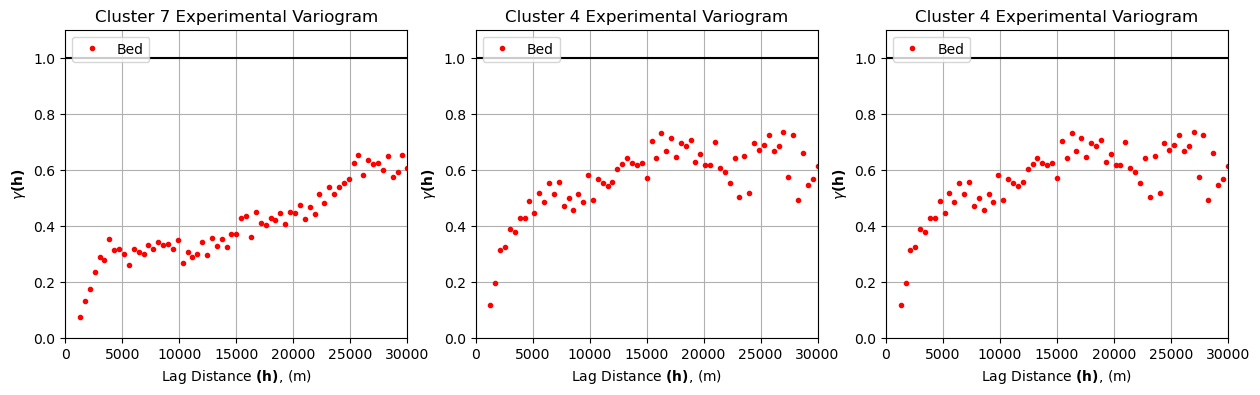

In [7]:
# plot 3 random experimental variograms

# choose 3 random cluster ids
rng = default_rng()
rints = rng.choice(n_clusters, 3)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for ax, rint in zip(axs, rints):
    ax.plot(variograms[rint].bins, variograms[rint].experimental, '.', color='r', label='Bed')
    ax.hlines(y=1.0, xmin=0, xmax=maxlag,color = 'black')
    ax.set_xlabel(r'Lag Distance $\bf(h)$, (m)')
    ax.set_ylabel(r'$\gamma \bf(h)$')
    ax.set_title(f'Cluster {rint} Experimental Variogram')
    ax.legend(loc='upper left')
    ax.set_xlim([0,maxlag])
    ax.set_ylim([0, 1.1])
    ax.grid(True)
plt.show()

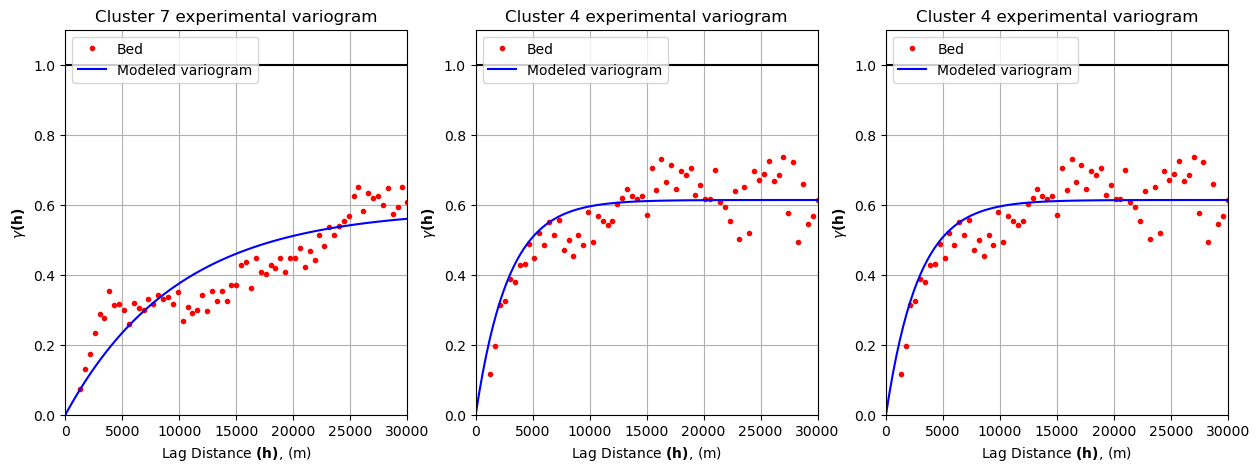

In [8]:
# fit variogram model

n = 100
lagh = np.linspace(0,maxlag,n) # create array of evenly spaced lag values to evaluate

# initialize space for modeled variograms
yy = np.zeros((len(variograms), len(lagh)))

# compute variograms
# c0 = sill
# r = effective range
# a = range
# b = nugget
for i, var in enumerate(variograms):
    c0 = var.parameters[1]
    r = var.parameters[0]
    a = r/3.
    b = 0
    
    yy[i,:] =  b+c0*(1.-np.exp(-(lagh/a)))
    
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for ax, rint in zip(axs, rints):
    ax.plot(variograms[rint].bins, variograms[rint].experimental, '.', color='red', label='Bed')
    ax.plot(lagh, yy[rint,:], '-', color='blue', label='Modeled variogram')
    ax.hlines(y=1.0, xmin=0, xmax=maxlag, color='black')
    ax.set_xlabel(r'Lag Distance $\bf(h)$, (m)')
    ax.set_ylabel(r'$\gamma \bf(h)$')
    ax.set_title(f'Cluster {rint} experimental variogram')
    ax.legend(loc='upper left')
    ax.set_xlim([0,maxlag])
    ax.set_ylim([0,1.1])
    ax.grid(True)
plt.show()

## Simulate with SGS

Next we will implement SGS with multiple variograms. This function is very similar to the original SGS. However, each time a grid cell is simulated, the nearest cluster is used to select the variogram that is used for that point. This is done as follows:

For each grid cell in a random path:
1. Find the nearest neighbors in the conditioning data, and determine which cluster the nearest point belongs to.
2. Look up the variogram parameters associated with that cluster.
3. Use simple kriging to estimate the mean and variance.
4. Sample from the distribution defined by the mean and variance. This is the simulated value.
5. Append the simulated value to the conditioning data, and give it the same cluster number that was found in Step 2.
6. Repeat steps 1-5 until every grid cell is simulated.

Note that the SGS clustering function (cluster_sgs) uses simple kriging. There is no ordinary kriging option.

In [9]:
# define coordinate grid
xmin = np.min(df_grid['X']); xmax = np.max(df_grid['X'])     # min and max x values
ymin = np.min(df_grid['Y']); ymax = np.max(df_grid['Y'])     # min and max y values

Pred_grid_xy = gs.Gridding.prediction_grid(xmin, xmax, ymin, ymax, res)

In [10]:
# make a dataframe with variogram parameters
azimuth = 0
nug = 0 # nugget effect
vtype = 'Exponential'

# define variograms for each cluster and store parameters
# Azimuth, nugget, major range, minor range, sill
varlist = [[azimuth,
            nug,
            var.parameters[0],
            var.parameters[0],
            var.parameters[1],
            vtype] for var in variograms]

df_gamma = pd.DataFrame({'Variogram': varlist})

In [11]:
# simulate

k = 100               # number of neighboring data points used to estimate a given point 
rad = 50000           # 50 km search radius

sgs = gs.Interpolation.cluster_sgs(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', 'K', k, df_gamma, rad) 

# reverse normal score transformation
sgs = sgs.reshape(-1,1)
sgs_trans = nst_trans.inverse_transform(sgs)

100%|████████████████████████████████████| 22500/22500 [03:30<00:00, 106.84it/s]


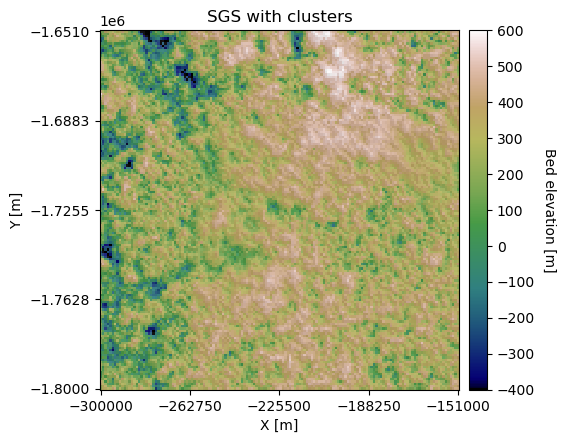

In [12]:
# make hillshade for visualizing
vmin = -400; vmax = 600
x_mat = Pred_grid_xy[:,0].reshape((rows, cols))
y_mat = Pred_grid_xy[:,1].reshape((rows, cols))
mat = sgs_trans.reshape((rows, cols))
xmin = Pred_grid_xy[:,0].min(); xmax = Pred_grid_xy[:,0].max()
ymin = Pred_grid_xy[:,1].min(); ymax = Pred_grid_xy[:,1].max()
    
cmap=plt.get_cmap('gist_earth')
fig, ax = plt.subplots(1, figsize=(5,5))
im = ax.pcolormesh(x_mat, y_mat, mat, vmin=vmin, vmax=vmax, cmap=cmap)
    
# Shade from the northeast, with the sun 45 degrees from horizontal
ls = LightSource(azdeg=45, altdeg=45)
        
# leaving the dx and dy as 1 means a vertical exageration equal to dx/dy
hillshade = ls.hillshade(mat, vert_exag=1, dx=1, dy=1, fraction=1.0)
plt.pcolormesh(x_mat, y_mat, hillshade, cmap='gray', alpha=0.1)
plt.title('SGS with clusters')
plt.xlabel('X [m]'); plt.ylabel('Y [m]')
plt.xticks(np.linspace(xmin, xmax, 5))
plt.yticks(np.linspace(ymin, ymax, 5))

# make colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(-400, 600, 11), cax=cax)
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=15)
ax.axis('scaled')
plt.show()

You can see that some regions appear rougher than others. We can also change the Azimuth and anisotropy in different clusters:

In [13]:
# introduce anisototropry and change azimuth and sill
varlist[12][0] = 45
varlist[12][2] += 15000
varlist[1][4] = 0.6
varlist[6][0] = 90
varlist[6][2] += 15000

df_gamma = pd.DataFrame({'Variogram': varlist})

sgs2 = gs.Interpolation.cluster_sgs(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', 'K', k, df_gamma, rad) 

# reverse normal score transformation
sgs2 = sgs2.reshape(-1,1)
sgs2_trans = nst_trans.inverse_transform(sgs2)

100%|████████████████████████████████████| 22500/22500 [03:30<00:00, 107.11it/s]


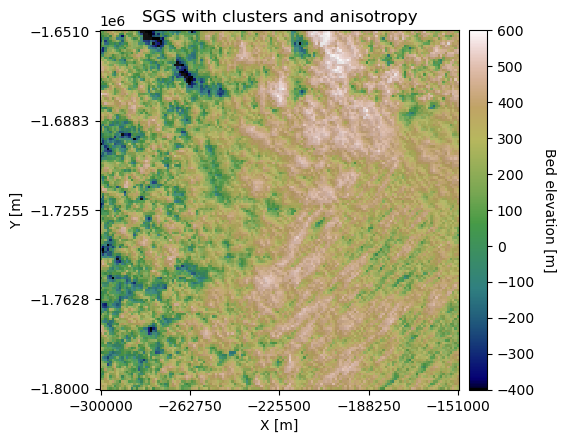

In [14]:
# make hillshade for visualizing
vmin = -400; vmax = 600
x_mat = Pred_grid_xy[:,0].reshape((rows, cols))
y_mat = Pred_grid_xy[:,1].reshape((rows, cols))
mat = sgs2_trans.reshape((rows, cols))
xmin = Pred_grid_xy[:,0].min(); xmax = Pred_grid_xy[:,0].max()
ymin = Pred_grid_xy[:,1].min(); ymax = Pred_grid_xy[:,1].max()
    
cmap=plt.get_cmap('gist_earth')
fig, ax = plt.subplots(1, figsize=(5,5))
im = ax.pcolormesh(x_mat, y_mat, mat, vmin=vmin, vmax=vmax, cmap=cmap)
    
# Shade from the northeast, with the sun 45 degrees from horizontal
ls = LightSource(azdeg=45, altdeg=45)
        
# leaving the dx and dy as 1 means a vertical exageration equal to dx/dy
hillshade = ls.hillshade(mat, vert_exag=1, dx=1, dy=1, fraction=1.0)
plt.pcolormesh(x_mat, y_mat, hillshade, cmap='gray', alpha=0.1)
plt.title('SGS with clusters and anisotropy')
plt.xlabel('X [m]'); plt.ylabel('Y [m]')
plt.xticks(np.linspace(xmin, xmax, 5))
plt.yticks(np.linspace(ymin, ymax, 5))

# make colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(-400, 600, 11), cax=cax)
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=15)
ax.axis('scaled')
plt.show()

There are some visible differences in the topography orientation.

Download the tutorial {Download}`here<./8_non-stationary_SGS_example2.ipynb>`.